In [1]:
import sys
import cv2
from matplotlib import pyplot as plt
import numpy as np
import traceback
from PIL import Image 

In [2]:
sys.setrecursionlimit(10 ** 6)

In [3]:
# this function put detected lines into arrays and returns them
def line_array(array):
    list_x_upper = []
    list_x_lower = []
    for y in range(5, len(array) - 5):
        s_a, s_p = strtline(y, array)
        e_a, e_p = endline(y, array)
        if s_a >= 7 and s_p >= 5:
            list_x_upper.append(y)
        if e_a >= 5 and e_p >= 7:
            list_x_lower.append(y)
    return list_x_upper, list_x_lower


# this function returns starting line
def strtline(y, array):
    count_ahead = 0
    count_prev = 0
    for i in array[y:y + 10]:
        if i > 3:
            count_ahead += 1
    for i in array[y - 10:y]:
        if i == 0:
            count_prev += 1
    return count_ahead, count_prev


# this function returns ending line
def endline(y, array):
    count_ahead = 0
    count_prev = 0
    for i in array[y:y + 10]:
        if i == 0:
            count_ahead += 1
    for i in array[y - 10:y]:
        if i > 3:
            count_prev += 1
    return count_ahead, count_prev


def endline_word(y, array, a):
    count_ahead = 0
    count_prev = 0
    for i in array[y:y + 2 * a]:
        if i < 2:
            count_ahead += 1
    for i in array[y - a:y]:
        if i > 2:
            count_prev += 1
    return count_prev, count_ahead


def end_line_array(array, a):
    list_endlines = []
    for y in range(len(array)):
        e_p, e_a = endline_word(y, array, a)
        if e_a >= int(1.5 * a) and e_p >= int(0.7 * a):
            list_endlines.append(y)
    return list_endlines


def refine_endword(array):
    refine_list = []
    for y in range(len(array) - 1):
        if array[y] + 1 < array[y + 1]:
            refine_list.append(array[y])
    return refine_list


def refine_array(array_upper, array_lower):
    upperlines = []
    lowerlines = []
    for y in range(len(array_upper) - 1):
        if array_upper[y] + 5 < array_upper[y + 1]:
            upperlines.append(array_upper[y] - 10)
    for y in range(len(array_lower) - 1):
        if array_lower[y] + 5 < array_lower[y + 1]:
            lowerlines.append(array_lower[y] + 10)

    upperlines.append(array_upper[-1] - 10)
    lowerlines.append(array_lower[-1] + 10)

    return upperlines, lowerlines


# this function returns mean letter width
def letter_width(contours):
    letter_width_sum = 0
    count = 0
    for cnt in contours:
        if cv2.contourArea(cnt) > 20:
            x, y, w, h = cv2.boundingRect(cnt)
            letter_width_sum += w
            count += 1

    return letter_width_sum / count


def end_wrd_dtct(lines, i, bin_img, mean_lttr_width, width, final_thr):
    count_y = np.zeros(shape=width)
    for x in range(width):
        for y in range(lines[i][0], lines[i][1]):
            if bin_img[y][x] == 255:
                count_y[x] += 1
    end_lines = end_line_array(count_y, int(mean_lttr_width))
    endlines = refine_endword(end_lines)
    for x in endlines:
        final_thr[lines[i][0]:lines[i][1], x] = 255
    return endlines


# process of segmentation
def image_segmentation(src_img ):
    # image thresholding
    try:
        

#         #-------------/Thresholding Image-------------#
#         print("start.........")
#         src_img = cv2.imread('7.png')

        copy = src_img.copy()
        height = src_img.shape[0]
        width = src_img.shape[1]

        src_img_copy = src_img.copy()

        src_img = cv2.resize(copy, dsize=(1320, int(1320 * height / width)), interpolation=cv2.INTER_AREA)

        height = src_img.shape[0]
        width = src_img.shape[1]

        grey_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)

        bin_img = cv2.adaptiveThreshold(grey_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 20)
        bin_img1 = bin_img.copy()
        bin_img2 = bin_img.copy()

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        kernel1 = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]], dtype=np.uint8)

        final_thr = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)
        contr_retrival = final_thr.copy()
        
#         plt.title("After thresholding the image")
#         plt.imshow(bin_img)
#         plt.show()

        # /image thresholding

        # line detection
        count_x = np.zeros(shape=(height))
        for y in range(height):
            for x in range(width):
                if bin_img[y][x] == 255:
                    count_x[y] = count_x[y] + 1

        upper_lines, lower_lines = line_array(count_x)

        upperlines, lowerlines = refine_array(upper_lines, lower_lines)

        if len(upperlines) == len(lowerlines):
            lines = []
            for y in upperlines:
                final_thr[y][:] = 255
            for y in lowerlines:
                final_thr[y][:] = 255
            for y in range(len(upperlines)):
                lines.append((upperlines[y], lowerlines[y]))

        else:
            while 1:
                k = cv2.waitKey(0)
                if k & 0xFF == ord('q'):
                    cv2.destroyAllWindows()
                    exit()

        lines = np.array(lines)

        no_of_lines = len(lines)

        lines_img = []

        for i in range(no_of_lines):
            lines_img.append(bin_img2[lines[i][0]:lines[i][1], :])

        # /line detection

        # line width calculation
        contours, hierarchy = cv2.findContours(contr_retrival, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        final_contr = np.zeros((final_thr.shape[0], final_thr.shape[1], 3), dtype=np.uint8)
        cv2.drawContours(src_img, contours, -1, (0, 255, 0), 1)

        mean_lttr_width = letter_width(contours)

        # /line width calculation

        # word detection
        x_lines = []

        for i in range(len(lines_img)):
            x_lines.append(end_wrd_dtct(lines, i, bin_img, mean_lttr_width, width, final_thr))

        for i in range(len(x_lines)):
            x_lines[i].append(width)

        # /word detection

        # character segmentation
        chr_img = bin_img1.copy()

        contours, hierarchy = cv2.findContours(chr_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        new_height = src_img.shape[0]
        new_width = src_img.shape[1]

        resized_image = cv2.resize(src_img_copy, (new_width, new_height))

        edges = []

        # getting x1, x2, y1, y2 edges of a letter for crop
        bbox_list = []
        for cnt in contours:
#             print(cv2.contourArea(cnt))
            if cv2.contourArea(cnt) > 20:
                x, y, w, h = cv2.boundingRect(cnt)
                temp = []
                temp.append(x)
                temp.append(y)
                temp.append(w)
                temp.append(h)
                edges.append(temp)
                cv2.rectangle(src_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                bbox_list.append([x,y,x+w,y+h])

        # reordering according to x index of edge for saving cropped image in oder
        n = len(edges)

        for i in range(n - 1):
            for j in range(0, n - i - 1):
                if edges[j][0] > edges[j + 1][0]:
                    edges[j], edges[j + 1] = edges[j + 1], edges[j]

        # cropping original image form letter edges
        i = 0
        for edge in edges:
            crop = resized_image[edge[1]:(edge[1] + edge[3]), edge[0]:(edge[0] + edge[2])]
            crop = cv2.resize(crop, (224, 224))
#             cv2.imwrite("segmentation_module/segmented_letters/crop_{0}.jpg".format(i), crop)
            i = i + 1

#         # /character segmentation
#         plt.title("Segmented points of the image")
#         plt.imshow(src_img)
#         plt.show()
        
#         plt.title("Segmented character image")
#         plt.imshow(resized_image)
#         plt.show()
        

        return resized_image,bbox_list

    except:
        print(traceback.print_exc())
        return False
def get_list_of_letters(src_img,bbox_list):
    letters_list = []
    pil_img = Image.fromarray(src_img)
    for index,row in enumerate(bbox_list):
        letters_list.append(pil_img.crop(row))
    return letters_list


In [4]:
# cv2.imread('7.png').shape,cv2.imread(img_path).shape

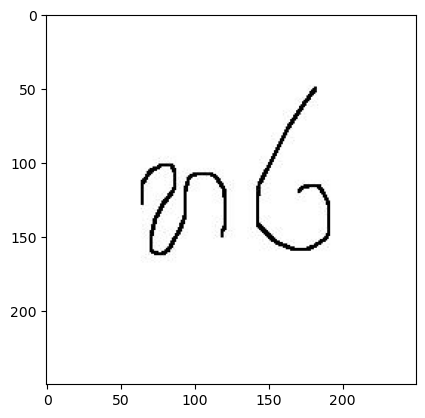

In [5]:

img_path =r"E:\iit files\fY\SinhalaTextRecognition\SinhalaTextRecognition\While_bg.jpeg"
plt.imshow(plt.imread(img_path))

In [6]:
src_img = cv2.imread(img_path)
src_img, bbox_list = image_segmentation(src_img)
bbox_list = sorted(bbox_list,key=lambda x:x[0])
letters_list_imgs = get_list_of_letters(src_img,bbox_list)

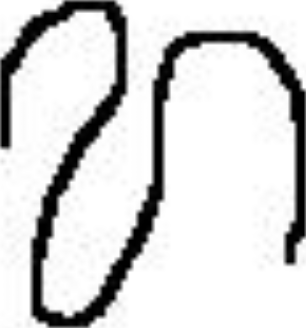

(328, 306, 3)
****************************************************************************************************


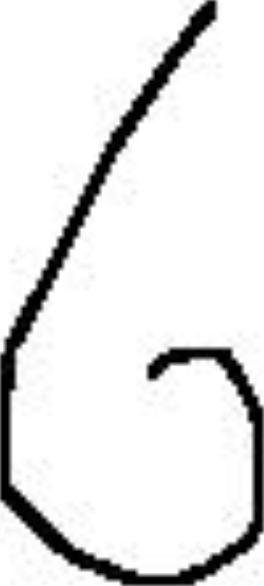

(586, 264, 3)
****************************************************************************************************


In [7]:
for img in letters_list_imgs:
    display(img )
    print(np.array(img).shape)
    print(100*"*")

Displaying Image 0


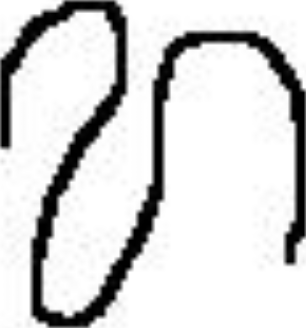

**************************************************
Displaying Image 1


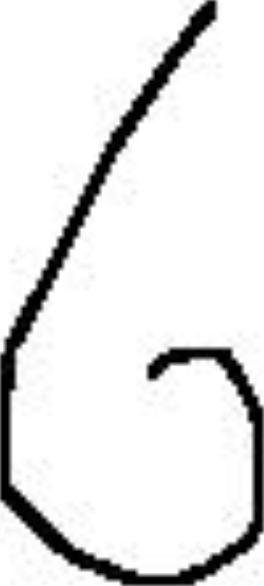

**************************************************


In [8]:
from PIL import Image 
pil_img = Image.fromarray(src_img)
for index,row in enumerate(bbox_list):
    print(f"Displaying Image {index}")
    display(pil_img.crop(row))
    print(50*"*")

In [9]:
#plt.imshow(plt.imread('7.png'))